<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Memory
from tempfile import mkdtemp
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV, SGDRegressor, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_regression, mutual_info_regression,f_classif
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle 


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
Feature_coef = pickle.load(open("save_Feature_coef.p", 'rb'))
Feature_coef = Feature_coef[0]
KB_Ridge = pickle.load(open("save_result2KB_ridge.p", 'rb'))
KB_Ridge = KB_Ridge[0]
RFECV_Ridge, RFECV_Lasso = pickle.load(open("save_result2KB_RFECV.p", 'rb'))
KB_LR, elasticNet, ridge, lasso = pickle.load(open("save_result2part.p", 'rb'))

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Data exploration

In [6]:
# Load the data
# Take NA as 'NA' instead of transfering to nan, since NA do have specific meaning in the data description.
house = pd.read_csv('./housing.csv', keep_default_na=False, na_values=[''])

In [7]:
# getting house info
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

In [8]:
# check house dimension
house.shape

(1460, 81)

In [9]:
# check the content of object column
# find LotFrontage, MasVnrArea, GarageYrBlt are numerical values that having missing data
for col in house.columns:
    if house[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'C (all)' 'FV' 'RH']
For the column LotFrontage, the unique values are ['65' '80' '68' '60' '84' '85' '75' 'NA' '51' '50' '70' '91' '72' '66'
 '101' '57' '44' '110' '98' '47' '108' '112' '74' '115' '61' '48' '33' '52'
 '100' '24' '89' '63' '76' '81' '95' '69' '21' '32' '78' '121' '122' '40'
 '105' '73' '77' '64' '94' '34' '90' '55' '88' '82' '71' '120' '107' '92'
 '134' '62' '86' '141' '97' '54' '41' '79' '174' '99' '67' '83' '43' '103'
 '93' '30' '129' '140' '35' '37' '118' '87' '116' '150' '111' '49' '96'
 '59' '36' '56' '102' '58' '38' '109' '130' '53' '137' '45' '106' '104'
 '42' '39' '144' '114' '128' '149' '313' '168' '182' '138' '160' '152'
 '124' '153' '46']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are ['NA' 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low'

In [10]:
# check numerial unique value
for col in house.columns:
    if house[col].dtypes != object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column Id, the unique values are [   1    2    3 ..., 1458 1459 1460]
For the column MSSubClass, the unique values are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
For the column LotArea, the unique values are [ 8450  9600 11250 ..., 17217 13175  9717]
For the column OverallQual, the unique values are [ 7  6  8  5  9  4 10  3  1  2]
For the column OverallCond, the unique values are [5 8 6 7 4 2 3 9 1]
For the column YearBuilt, the unique values are [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006 1960
 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966 1959 1994
 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972 1921 1945 1982
 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985 1979 1885 1919 1990
 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926 1940 1941 1987 1986 2008
 1908 1892 1916 1932 1918 1912 1947 1925 1900 1980 1989 1992 1949 1880 1928
 1978 1922 1996 2010 1946 1913 1937 1942 1938 1974 1893 1914 1906 

In [11]:
# check MSZoning, there are non residential house
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [12]:
# remove non-residential house
residential = [True if ele in ['RL', 'RM', 'FV', 'RH'] else False for ele in house.MSZoning]
house_residential = house[residential].copy()
house_residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [13]:
# set LotFrontage NA value to 0, since there is no zero value exist, consider as input error, 0 feet is record as NA
# convert to int
house_residential.LotFrontage = [0 if ele=='NA' else int(ele) for ele in house_residential.LotFrontage]

In [14]:
# recheck the value of LotFrontage
house_residential['LotFrontage'].unique()

array([ 65,  80,  68,  60,  84,  85,  75,   0,  51,  50,  70,  91,  72,
        66, 101,  57,  44, 110,  98,  47, 108, 112,  74, 115,  61,  48,
        33,  52, 100,  24,  89,  63,  76,  81,  95,  69,  21,  32,  78,
       121, 122,  40,  73,  77,  64,  94, 105,  34,  90,  55,  88,  82,
        71, 120, 107,  92, 134,  62,  86, 141,  97,  54,  41,  79, 174,
        99,  67,  83,  43, 103,  93,  30, 129, 140,  35,  37, 118,  87,
       116, 150, 111,  49,  96,  59,  36,  56, 102,  58,  38, 109, 130,
        53, 137,  45, 106, 104,  42,  39, 144, 114, 128, 149, 313, 168,
       182, 138, 160, 152, 124, 153,  46], dtype=int64)

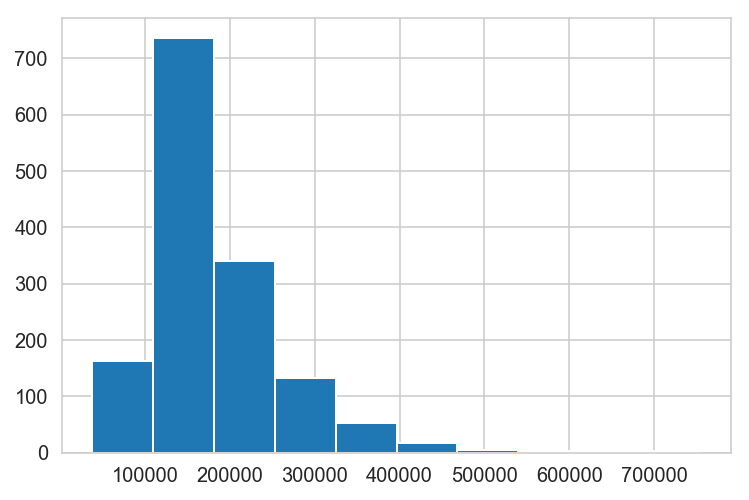

In [15]:
# Take a look of the house price distribution
# there are few very large values
house_residential.SalePrice.hist()

In [16]:
# checking basment exposure, No is no exposure, NA is no basement
house_residential.BsmtExposure.value_counts()

No    947
Av    219
Gd    134
Mn    112
NA     38
Name: BsmtExposure, dtype: int64

In [17]:
# Take a look at the no basement house
# item 948 basement exist, BsmtExposure change to No
house_residential.loc[house_residential.BsmtExposure=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NA,NA,NA,NA,0,NA,0,0,0,0
39,NA,NA,NA,NA,0,NA,0,0,0,0
90,NA,NA,NA,NA,0,NA,0,0,0,0
102,NA,NA,NA,NA,0,NA,0,0,0,0
156,NA,NA,NA,NA,0,NA,0,0,0,0
182,NA,NA,NA,NA,0,NA,0,0,0,0
259,NA,NA,NA,NA,0,NA,0,0,0,0
342,NA,NA,NA,NA,0,NA,0,0,0,0
362,NA,NA,NA,NA,0,NA,0,0,0,0
371,NA,NA,NA,NA,0,NA,0,0,0,0


In [18]:
# setting 948, 'BsmtExposure' = 'No'
house_residential.loc[948, 'BsmtExposure'] = 'No'

In [19]:
# checking other basement related columns
# item 332 basement exist but missing BsmtFinType2 (NA means no basement, which is not the incorrect info of this house)
house_residential.loc[house_residential.BsmtFinType2=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NA,NA,NA,NA,0,NA,0,0,0,0
39,NA,NA,NA,NA,0,NA,0,0,0,0
90,NA,NA,NA,NA,0,NA,0,0,0,0
102,NA,NA,NA,NA,0,NA,0,0,0,0
156,NA,NA,NA,NA,0,NA,0,0,0,0
182,NA,NA,NA,NA,0,NA,0,0,0,0
259,NA,NA,NA,NA,0,NA,0,0,0,0
332,Gd,TA,No,GLQ,1124,NA,479,3206,1,0
342,NA,NA,NA,NA,0,NA,0,0,0,0
362,NA,NA,NA,NA,0,NA,0,0,0,0


In [20]:
# setting 332, 'BsmtFinType2' = 'othr'
house_residential.loc[332, 'BsmtFinType2'] = 'othr'

In [21]:
# some house missing masonry veneer type, set area to 0
house_residential.loc[house_residential.MasVnrArea=='NA',['MasVnrType','MasVnrArea' ]]

,MasVnrType,MasVnrArea
234,NA,NA
529,NA,NA
650,NA,NA
936,NA,NA
973,NA,NA
977,NA,NA
1243,NA,NA
1278,NA,NA


In [22]:
house_residential.MasVnrArea = [0 if ele=='NA' else int(ele) for ele in house_residential.MasVnrArea]

In [23]:
# change None to NA, the None also repersent not exist. To keep the consistency with other columns
house_residential.loc[house_residential.MasVnrType=='None','MasVnrType']='NA'

In [24]:
# fit the missing electrical with the most common type SBrkr, since in the dictionary do not indicate what is NA repersent for
# Electrical, take ask incorrect input
house_residential.loc[house_residential.Electrical=='NA','Electrical']= house_residential.Electrical.value_counts().index[0]

In [25]:
# Checking Garage info
house_residential.loc[house_residential.GarageYrBlt=='NA',['GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']]


,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt
39,NA,NA,NA,NA,NA
48,NA,NA,NA,NA,NA
78,NA,NA,NA,NA,NA
89,NA,NA,NA,NA,NA
99,NA,NA,NA,NA,NA
108,NA,NA,NA,NA,NA
125,NA,NA,NA,NA,NA
127,NA,NA,NA,NA,NA
140,NA,NA,NA,NA,NA
148,NA,NA,NA,NA,NA


In [26]:
# set garageYrBlt to numerical, NA to 0, varified with GarageCond, this column later will be used in garage age calculation,
# put no garage build year as 0 for now
house_residential.GarageYrBlt = [0 if ele=='NA' else int(ele) for ele in house_residential.GarageYrBlt]

In [27]:
# recheck the object data
for col in house_residential.columns:
    if house_residential[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house_residential[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'FV' 'RH']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are ['NA' 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low' 'HLS']
For the column Utilities, the unique values are ['AllPub' 'NoSeWa']
For the column LotConfig, the unique values are ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
For the column LandSlope, the unique values are ['Gtl' 'Mod' 'Sev']
For the column Neighborhood, the unique values are ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
For the column Condition1, the unique values are ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
For the column C

In [28]:
# recheck the numerial data
house_residential.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,57.54000,10523.831724,6.114483,5.582069,1971.593103,1985.049655,103.828276,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,34.71992,10012.185355,1.372860,1.107330,30.022696,20.552319,181.150114,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,0.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,41.25000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,63.00000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,79.00000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.000000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.00000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Feature engieering

In [29]:
# merge the Porch area
house_residential['PorchSF'] = house_residential[['OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)

In [30]:
# add the age of building when it was sold
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='YearBuilt')[0,0] +1), column='sold_built_age', value=(house_residential.YrSold - house_residential.YearBuilt))

In [31]:
# add age of the renovation of the building when it was sold
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='YearRemodAdd')[0,0] +1), column='sold_Remod_age', value=(house_residential.YrSold - house_residential.YearRemodAdd))

In [32]:
# there is one building that renovated after sold, so change the value to 0, means newly renovated when sold
house_residential.loc[house_residential.sold_Remod_age==-1, ['sold_Remod_age', 'YearRemodAdd', 'YrSold', 'YearBuilt']]

,sold_Remod_age,YearRemodAdd,YrSold,YearBuilt
523,-1,2008,2007,2007


In [33]:
house_residential.loc[house_residential.sold_Remod_age==-1, 'sold_Remod_age'] = 0

In [34]:
# add Garage age
gAge = (house_residential.YrSold - house_residential.GarageYrBlt)

In [35]:
# get a list whether there is garage, by checking the age of the garage
H_gar = [1 if age<200 else 0 for age in gAge]

In [36]:
# fixed the house without garage to garage age = 1000, will be compensate by the having garage column
gAge = [age if age<200 else 1000 for age in gAge]

In [37]:
# add garage age
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='GarageYrBlt')[0,0] +1), column='sold_Garage_age', value=gAge)

In [38]:
# add where have garage
house_residential.insert(loc = int(np.argwhere(house_residential.columns=='GarageYrBlt')[0,0] +1), column='have_garage', value=H_gar)

In [39]:
# check Garage info
house_residential[['sold_Garage_age', 'sold_Remod_age', 'sold_built_age']].describe()

,sold_Garage_age,sold_Remod_age,sold_built_age
count,1450.000000,1450.000000,1450.000000
mean,82.075862,22.763448,36.219310
std,221.717391,20.540721,30.064048
min,0.000000,0.000000,0.000000
25%,7.000000,4.000000,7.000000
50%,30.000000,14.000000,34.000000
75%,50.000000,41.000000,54.000000
max,1000.000000,60.000000,136.000000


In [40]:
# all column of the data
house_residential.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'sold_built_age', 'YearRemodAdd', 'sold_Remod_age', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'have_garage', 'sold_Garage_age', 'GarageFinish

## Fixed ch selecting

In [41]:
fixed_ch = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
            'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'sold_built_age', 'sold_Remod_age',  'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
            'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
            'TotRmsAbvGrd', 'Fireplaces', 'have_garage', 'GarageType', 'sold_Garage_age', 'GarageCars',
            'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
            '3SsnPorch', 'ScreenPorch','PorchSF','PoolArea',
            'MiscFeature', 'MiscVal']

In [42]:
# check the rest of the column
rest_ch = [col for col in house_residential.columns if col not in fixed_ch]
rest_ch = rest_ch[1:-1]
rest_ch

['OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

## Review time factors

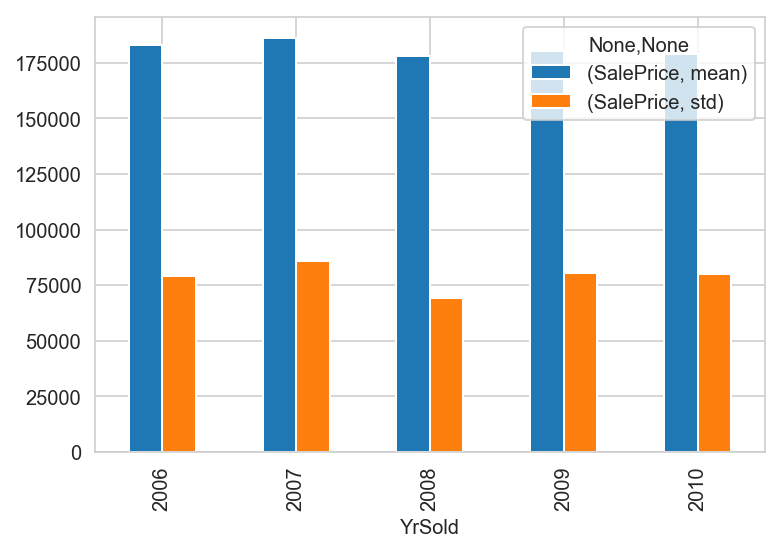

In [43]:
# plot sold year price info
house_residential.groupby(['YrSold']).agg({'SalePrice': ['mean','std'] }).plot(kind='bar')

In [44]:
# setting functions to check the significant difference by p-value, if nothing print, means no significant different


def p_year_test(house_residential, year1, year2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.YrSold==year1, 'SalePrice'],house_residential.loc[ house_residential.YrSold==year2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {year1} and {year2} the p_value is {p_value}\n')

        
def p_year_build_test(house_residential, year1, year2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.YearBuilt==year1, 'SalePrice'],house_residential.loc[ house_residential.YearBuilt==year2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {year1} and {year2} the p_value is {p_value}\n')        
        
        
        
def p_month_test(house_residential, m1, m2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.MoSold==m1, 'SalePrice'],house_residential.loc[ house_residential.MoSold==m2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {m1} and {m2} the p_value is {p_value}\n')

In [45]:
# check if there is significant difference between the price of each sold year
# no significant difference, it is possible to use pass year data to predict 2010 price
for year in range(2006,2011):
    for compare in range(year+1,2011):
        p_year_test(house_residential, year, compare)

In [46]:
# check whether there is significant difference between the price of building year
# build year do give difference
for year in range(1950,2011):
    for compare in range(year+1,2011):
        p_year_build_test(house_residential, year, compare)

Between 1950 and 1960 the p_value is 0.006999309961260744

Between 1950 and 1964 the p_value is 0.0019898023011491015

Between 1950 and 1966 the p_value is 0.016036172417833224

Between 1950 and 1968 the p_value is 0.0027678743161151237

Between 1950 and 1969 the p_value is 0.008395118412309936

Between 1950 and 1974 the p_value is 0.001205281675727996

Between 1950 and 1976 the p_value is 0.003829503311702932

Between 1950 and 1977 the p_value is 0.0004173916377547709

Between 1950 and 1978 the p_value is 0.006518684319980653

Between 1950 and 1980 the p_value is 0.0167371288557425

Between 1950 and 1981 the p_value is 3.292807010855059e-05

Between 1950 and 1983 the p_value is 0.045815783936969424

Between 1950 and 1984 the p_value is 0.012397132311155848

Between 1950 and 1985 the p_value is 0.004018085628005743

Between 1950 and 1986 the p_value is 0.00019438595336002066

Between 1950 and 1987 the p_value is 0.0034311087920962887

Between 1950 and 1988 the p_value is 2.013488234219

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\numpy\core\fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Between 1951 and 2008 the p_value is 0.00012859491217742945

Between 1951 and 2009 the p_value is 0.00889762423633754

Between 1952 and 1964 the p_value is 0.013466820031048692

Between 1952 and 1974 the p_value is 0.048957809597974446

Between 1952 and 1977 the p_value is 0.035413362842357646

Between 1952 and 1981 the p_value is 0.029340575578824298

Between 1952 and 1986 the p_value is 0.023541723318021963

Between 1952 and 1987 the p_value is 0.03870382692428334

Between 1952 and 1988 the p_value is 0.0016684743658135124

Between 1952 and 1989 the p_value is 0.005156190345187543

Between 1952 and 1990 the p_value is 0.009670863644701159

Between 1952 and 1992 the p_value is 0.03129589747126209

Between 1952 and 1993 the p_value is 0.006905168127968954

Between 1952 and 1995 the p_value is 0.039084460566539775

Between 1952 and 1997 the p_value is 0.0015069343504795622

Between 1952 and 1998 the p_value is 0.002373534061734119

Between 1952 and 1999 the p_value is 0.0048990202219563


Between 1959 and 1989 the p_value is 0.0004261530331626915

Between 1959 and 1990 the p_value is 0.0011513298541580925

Between 1959 and 1992 the p_value is 0.0032884207014623225

Between 1959 and 1993 the p_value is 0.0005092557417918222

Between 1959 and 1994 the p_value is 0.0036040054337872158

Between 1959 and 1995 the p_value is 0.00021554666674697856

Between 1959 and 1996 the p_value is 0.0017151726803417999

Between 1959 and 1997 the p_value is 0.0005506072851452538

Between 1959 and 1998 the p_value is 4.915934070055105e-05

Between 1959 and 1999 the p_value is 0.00036655188986267916

Between 1959 and 2000 the p_value is 7.87159052187109e-05

Between 1959 and 2001 the p_value is 3.1196670155224485e-06

Between 1959 and 2002 the p_value is 5.899379358465322e-07

Between 1959 and 2003 the p_value is 0.00011066959035652755

Between 1959 and 2004 the p_value is 0.00018881266995527648

Between 1959 and 2005 the p_value is 3.242584005032029e-05

Between 1959 and 2006 the p_value i


Between 1964 and 1993 the p_value is 0.0015737338769800816

Between 1964 and 1994 the p_value is 0.028913204128204674

Between 1964 and 1995 the p_value is 0.0037365255883595955

Between 1964 and 1996 the p_value is 0.016020766859564245

Between 1964 and 1997 the p_value is 0.00026542472804870606

Between 1964 and 1998 the p_value is 0.00037331609898098406

Between 1964 and 1999 the p_value is 0.002082320433151505

Between 1964 and 2000 the p_value is 0.00012794785285341007

Between 1964 and 2001 the p_value is 2.8040835030246293e-05

Between 1964 and 2002 the p_value is 1.4323610372632213e-07

Between 1964 and 2003 the p_value is 0.003622034899514504

Between 1964 and 2004 the p_value is 0.005375152985851034

Between 1964 and 2005 the p_value is 0.002124439659853535

Between 1964 and 2006 the p_value is 5.383469040198645e-05

Between 1964 and 2007 the p_value is 5.898656876834775e-06

Between 1964 and 2008 the p_value is 3.5120295910849254e-07

Between 1964 and 2009 the p_value is 0.

Between 1974 and 2006 the p_value is 0.010693402835575029

Between 1974 and 2007 the p_value is 0.003587216585301447

Between 1974 and 2008 the p_value is 0.00012642722848391796

Between 1974 and 2009 the p_value is 0.028511207213204433

Between 1975 and 1981 the p_value is 0.038592319340582396

Between 1975 and 1988 the p_value is 0.04121703859797539

Between 1975 and 1989 the p_value is 0.009678642378506073

Between 1975 and 1990 the p_value is 0.03274219084376401

Between 1975 and 1993 the p_value is 0.02624779567443235

Between 1975 and 1995 the p_value is 0.032599029735894555

Between 1975 and 1997 the p_value is 0.01596079459348118

Between 1975 and 1998 the p_value is 0.01033017985201405

Between 1975 and 1999 the p_value is 0.026823950579631703

Between 1975 and 2000 the p_value is 0.007854489049867899

Between 1975 and 2001 the p_value is 0.0025195679976594827

Between 1975 and 2002 the p_value is 0.00030266878604093413

Between 1975 and 2003 the p_value is 0.02904332261353567

Between 1982 and 1992 the p_value is 0.014144719016742982

Between 1982 and 1993 the p_value is 0.0021564473269512965

Between 1982 and 1995 the p_value is 0.01756290739596871

Between 1982 and 1996 the p_value is 0.049024453295710056

Between 1982 and 1997 the p_value is 0.00024476013955518914

Between 1982 and 1998 the p_value is 0.0006091679060083547

Between 1982 and 1999 the p_value is 0.0016152347489669337

Between 1982 and 2000 the p_value is 7.148685098293523e-05

Between 1982 and 2001 the p_value is 0.0002259623269899934

Between 1982 and 2002 the p_value is 4.0226663715740794e-07

Between 1982 and 2003 the p_value is 0.007234929804930258

Between 1982 and 2004 the p_value is 0.004396503860796291

Between 1982 and 2005 the p_value is 0.004973886317524403

Between 1982 and 2006 the p_value is 0.0005738888115005835

Between 1982 and 2007 the p_value is 0.00011514680636103648

Between 1982 and 2008 the p_value is 9.749136459893467e-05

Between 1982 and 2009 the p_value is 0.00700

In [47]:
# month infor also useful, keep the month column for later

for m1 in range(1,13):
    for m2 in range(m1+1,13):
        p_month_test(house_residential, m1, m2)

Between 4 and 9 the p_value is 0.040058419468244975

Between 4 and 11 the p_value is 0.043115189130592556

Between 5 and 9 the p_value is 0.018639526613212224

Between 5 and 11 the p_value is 0.020106790809764075



## Train test splite

In [48]:
# split by year
train_data = house_residential[house_residential.YrSold< 2010 ].copy()
test_data = house_residential[house_residential.YrSold == 2010 ].copy()

In [49]:
# check length
(len(train_data)+len(test_data)) == len(house_residential)

True

In [50]:
# 1278 training data, 172 testing data
print((len(train_data), len(test_data)))

(1278, 172)


## Get dummies

In [51]:
# for training set, get predictor and target

fixed_predictor = train_data[fixed_ch]
y_train = train_data.SalePrice

In [52]:
# convert all categorical data and MSsubClass as dummies
object_col = [col for col in fixed_ch if fixed_predictor[col].dtype==object]
dummy_num_col = ['MSSubClass']
dummy_col = dummy_num_col + object_col
X_train = pd.get_dummies(fixed_predictor, columns=dummy_col, drop_first=True)
# no object datatype
np.argwhere(X_train.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [53]:
# for testing set do the same

fixed_predictor = test_data[fixed_ch]
y_test = test_data.SalePrice
X_test = pd.get_dummies(fixed_predictor, columns=dummy_col, drop_first=True)
# no object
np.argwhere(X_test.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [54]:
# size of training and testing does not match
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((1278, 136), (1278,), (172, 116), (172,))

In [55]:
# there are categoies do not exist in testing data
missing_col = [col for col in X_train.columns if col not in X_test.columns]
missing_col

['MSSubClass_45',
 'MSSubClass_75',
 'MSZoning_RH',
 'LotShape_IR3',
 'Utilities_NoSeWa',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Neighborhood_Veenker',
 'Condition2_Feedr',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'GarageType_Attchd',
 'MiscFeature_NA',
 'MiscFeature_TenC']

In [56]:
# testing data do not have additonal category than training data
[col for col in X_test.columns if col not in X_train.columns]

[]

In [57]:
# refill the missing columns
missing_col_loc = [np.argwhere(X_train.columns==col)[0,0] for col in missing_col]

In [58]:
missing_col_loc

[31,
 35,
 43,
 50,
 55,
 58,
 62,
 85,
 94,
 96,
 97,
 98,
 99,
 100,
 105,
 107,
 108,
 124,
 132,
 135]

In [59]:
list(enumerate(X_train.columns))

[(0, 'LotFrontage'),
 (1, 'LotArea'),
 (2, 'sold_built_age'),
 (3, 'sold_Remod_age'),
 (4, 'MasVnrArea'),
 (5, 'TotalBsmtSF'),
 (6, '1stFlrSF'),
 (7, '2ndFlrSF'),
 (8, 'GrLivArea'),
 (9, 'BsmtFullBath'),
 (10, 'BsmtHalfBath'),
 (11, 'FullBath'),
 (12, 'HalfBath'),
 (13, 'BedroomAbvGr'),
 (14, 'KitchenAbvGr'),
 (15, 'TotRmsAbvGrd'),
 (16, 'Fireplaces'),
 (17, 'have_garage'),
 (18, 'sold_Garage_age'),
 (19, 'GarageCars'),
 (20, 'GarageArea'),
 (21, 'WoodDeckSF'),
 (22, 'OpenPorchSF'),
 (23, 'EnclosedPorch'),
 (24, '3SsnPorch'),
 (25, 'ScreenPorch'),
 (26, 'PorchSF'),
 (27, 'PoolArea'),
 (28, 'MiscVal'),
 (29, 'MSSubClass_30'),
 (30, 'MSSubClass_40'),
 (31, 'MSSubClass_45'),
 (32, 'MSSubClass_50'),
 (33, 'MSSubClass_60'),
 (34, 'MSSubClass_70'),
 (35, 'MSSubClass_75'),
 (36, 'MSSubClass_80'),
 (37, 'MSSubClass_85'),
 (38, 'MSSubClass_90'),
 (39, 'MSSubClass_120'),
 (40, 'MSSubClass_160'),
 (41, 'MSSubClass_180'),
 (42, 'MSSubClass_190'),
 (43, 'MSZoning_RH'),
 (44, 'MSZoning_RL'),
 (45, '

In [60]:
# fillin zeros for the missing columns
for i,locnumber in enumerate(missing_col_loc):
    X_test.insert(loc=int(locnumber), column=missing_col[i], value=[0 for ele in range(X_test.shape[0])])

In [61]:
X_test.iloc[:, missing_col_loc].head()

,MSSubClass_45,MSSubClass_75,MSZoning_RH,LotShape_IR3,Utilities_NoSeWa,LotConfig_FR3,Neighborhood_Blueste,Neighborhood_Veenker,Condition2_Feedr,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,GarageType_Attchd,MiscFeature_NA,MiscFeature_TenC
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
X_train.iloc[:, missing_col_loc].head()

,MSSubClass_45,MSSubClass_75,MSZoning_RH,LotShape_IR3,Utilities_NoSeWa,LotConfig_FR3,Neighborhood_Blueste,Neighborhood_Veenker,Condition2_Feedr,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,GarageType_Attchd,MiscFeature_NA,MiscFeature_TenC
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [63]:
# columns matched
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((1278, 136), (1278,), (172, 136), (172,))

## Train and validation

In [64]:
# model 1 LinearRegression
# very bad, will not take into consideration
scaler1 = StandardScaler()
lr = LinearRegression()
X_train_std = scaler1.fit_transform(X_train)
score1 = cross_val_score(lr, X_train_std, y_train, scoring='r2', cv=10)
np.mean(score1), np.std(score1)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(-3.0546012262963243e+21, 8.2167088226185521e+21)

In [65]:
# transfer the test data
X_test_std = scaler1.transform(X_test)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [67]:
# # model 2 Lasso
# # using Lasso model to remove features not important
# lassoCV = LassoCV(alphas=np.linspace(1000, 1050, 400), random_state=42, cv=10, max_iter=5000)
# lassoCV.fit(X_train_std, y_train)
# print(f'alpha is {lassoCV.alpha_}')
# lasso = Lasso(alpha=lassoCV.alpha_, random_state=42, max_iter=5000)
# score2 = cross_val_score(lasso, X_train_std, y_train, scoring='r2', cv=10)
# print(f"The CV score mean is {np.mean(score2)}, the CV score std is {np.std(score2)}")
# lasso.fit(X_train_std,y_train)
# lasso.score(X_test_std,y_test)

alpha is 1049.122807017544
The CV score mean is 0.793720141911953, the CV score std is 0.10466657233137884


0.85993251505694102

In [66]:
# # 61 non zero coef
# Feature_coef = pd.DataFrame(data=lasso.coef_, index=X_train.columns, columns=['Lasso'])
# Feature_coef.loc['Intercept', 'Lasso'] = lasso.intercept_
# Feature_coef.iloc[np.argsort(Feature_coef.Lasso.abs())[::-1]].head(64)

,Lasso
Intercept,181989.782473
GrLivArea,30033.235814
Neighborhood_NridgHt,13660.300075
GarageCars,8848.887990
Neighborhood_NoRidge,8481.441607
sold_built_age,-8130.589473
Neighborhood_StoneBr,7905.592264
sold_Remod_age,-7507.382419
TotalBsmtSF,6841.820319
BsmtExposure_Gd,5288.426124


In [68]:
# # model 3 ridge 
# # give best alpha is 419.7543859649123
# # The CV score mean 0.8002753855451216, the CV score std 0.09194925239891304
# # Test score 0.85833780033472973

# ridgeCV = RidgeCV(alphas=np.linspace(418, 425, 400), cv=10,scoring='r2')
# ridgeCV.fit(X_train_std, y_train)
# print(f'alpha is {ridgeCV.alpha_}')
# ridge = Ridge(alpha=ridgeCV.alpha_,random_state=42, max_iter=5000)
# score3 = cross_val_score(ridge,X_train_std, y_train, scoring='r2', cv=10)
# print(f"The CV score mean {np.mean(score3)}, the CV score std {np.std(score3)}")
# ridge.fit(X_train_std,y_train)
# ridge.score(X_test_std, y_test)

alpha is 419.7543859649123
The CV score mean 0.8002753855451216, the CV score std 0.09194925239891304


0.85833780033472973

In [67]:
# # add Ridge coef
# Feature_coef.loc[:-1,'Ridge'] = ridge.coef_
# Feature_coef.loc['Intercept','Ridge'] = ridge.intercept_
# Feature_coef.iloc[np.argsort(Feature_coef.Ridge.abs())[::-1]].head(64)

,Lasso,Ridge
Intercept,181989.782473,181989.782473
GrLivArea,30033.235814,10032.183026
Neighborhood_NridgHt,13660.300075,9093.518169
1stFlrSF,0.000000,7163.632286
Neighborhood_NoRidge,8481.441607,6987.995716
TotalBsmtSF,6841.820319,6138.046744
GarageCars,8848.887990,6105.168984
Neighborhood_StoneBr,7905.592264,6056.548518
sold_Remod_age,-7507.382419,-5958.625057
2ndFlrSF,0.000000,5778.439952


In [69]:
# # model 4 elasticNet

# # The l1 ration is 0.989909090909091, the alpha is 56.56489665034848
# # The CV score mean 0.798557630089781, the CV score std 0.08867224983754936
# # Test score is 0.8471841575049972

# l1_ratios=np.linspace(0.001, 1, 100)
# n_alpha = 1000

# elasticNetCV = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=n_alpha, cv=10, max_iter=5000, random_state=42)
# elasticNetCV.fit(X_train_std, y_train)

# print(f"The l1 ration is {elasticNetCV.l1_ratio_}, the alpha is {elasticNetCV.alpha_}")
# elasticNet = ElasticNet(alpha=elasticNetCV.alpha_, l1_ratio=elasticNetCV.l1_ratio_, max_iter=5000)
# score4 = cross_val_score(elasticNet,X_train_std, y_train, scoring='r2', cv=10)
# print(f"The CV score mean {np.mean(score4)}, the CV score std {np.std(score4)}")

# elasticNet.fit(X_train_std, y_train)

# elasticNet.score(X_test_std, y_test)

The l1 ration is 0.989909090909091, the alpha is 56.56489665034848
The CV score mean 0.798557630089781, the CV score std 0.08867224983754936


0.8471841575049972

In [68]:
# ## add elastic net feature
# Feature_coef.loc[:-1,'ElasticNet'] = elasticNet.coef_
# Feature_coef.loc['Intercept','ElasticNet'] = elasticNet.intercept_
# Feature_coef.iloc[np.argsort(Feature_coef.ElasticNet.abs())[::-1]].head(64)

,Lasso,Ridge,ElasticNet
Intercept,181989.782473,181989.782473,181989.782473
GrLivArea,30033.235814,10032.183026,8834.099205
Neighborhood_NridgHt,13660.300075,9093.518169,7736.278682
1stFlrSF,0.000000,7163.632286,6875.843425
Neighborhood_NoRidge,8481.441607,6987.995716,6223.042593
TotalBsmtSF,6841.820319,6138.046744,6135.627051
GarageCars,8848.887990,6105.168984,5634.273831
sold_Remod_age,-7507.382419,-5958.625057,-5512.702908
TotRmsAbvGrd,2456.714998,5731.223419,5338.527856
Neighborhood_StoneBr,7905.592264,6056.548518,5169.593355


In [70]:
# # model 5 SelectKBest + LinearRegression
# # The CV score is 0.8080204316758324
# # Testing score is 0.84257821505187014
# # The best parameters are {'KB__k': 91, 'KB__score_func': <function mutual_info_regression at 0x000002918D6E2510>}

# pipeline_KB_LR = Pipeline([("KB", SelectKBest()), ("LR", LinearRegression())])

# print(f"Hyperparameter: {pipeline_KB_LR.get_params().keys()}")

# KB_LR_parameter = {"KB__k": list(range(1,100)),
#                   "KB__score_func": [f_regression, mutual_info_regression]}

# KB_LR = GridSearchCV(pipeline_KB_LR, KB_LR_parameter, cv=10, scoring="r2", n_jobs=3 )
# KB_LR.fit(X_train_std, y_train)

# print(f"The best parameters are {KB_LR.best_params_}")

Hyperparameter: dict_keys(['memory', 'steps', 'KB', 'LR', 'KB__k', 'KB__score_func', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])


C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


The best parameters are {'KB__k': 91, 'KB__score_func': <function mutual_info_regression at 0x000002918D6E2510>}


In [71]:
# print(f"The CV score is {KB_LR.best_score_}")
# KB_lR_predict = KB_LR.predict(X_test_std)
# r2_score(y_test, KB_lR_predict)

The CV score is 0.8080204316758324


0.84257821505187014

In [73]:
# set the best pipeline
pipeline_KB_LR = Pipeline([("KB", SelectKBest(k=91, score_func=mutual_info_regression)), ("LR", LinearRegression())])
pipeline_KB_LR.fit(X_train_std,y_train)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('KB', SelectKBest(k=91,
      score_func=<function mutual_info_regression at 0x000001B4605A2F28>)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [76]:
# add the feature coef
Feature_coef.loc[:,'KBest_LR']=0
kb_col = X_train.columns[pipeline_KB_LR.named_steps['KB'].get_support()]
Feature_coef.loc[kb_col,'KBest_LR']=pipeline_KB_LR.named_steps['LR'].coef_
Feature_coef.loc['Intercept','KBest_LR']=pipeline_KB_LR.named_steps['LR'].intercept_
Feature_coef.iloc[np.argsort(Feature_coef.KBest_LR.abs())[::-1]].head(64)

,Lasso,Ridge,ElasticNet,KBest_LR
GarageType_NA,0.000000,623.163308,337.373806,-4.140864e+16
have_garage,-0.000000,-623.163308,-337.057186,-4.140864e+16
BldgType_Duplex,-111.560248,-1409.213446,-1388.152235,-1.039181e+16
MSSubClass_90,-1153.261830,-1409.213446,-1388.090645,1.039181e+16
Intercept,181989.782473,181989.782473,181989.782473,1.819885e+05
2ndFlrSF,0.000000,5778.439952,4489.465547,2.373456e+04
Neighborhood_NridgHt,13660.300075,9093.518169,7736.278682,1.483029e+04
1stFlrSF,0.000000,7163.632286,6875.843425,1.341886e+04
GarageCars,8848.887990,6105.168984,5634.273831,1.172990e+04
MasVnrType_NA,0.000000,505.407405,-176.679035,1.019327e+04


In [ ]:
# # model 7 SelectKBest + Ridge (cv)


# pipeline_KB_Ridge = Pipeline([("KB", SelectKBest()), ("Ridge", RidgeCV(cv=5))])

# print(f"Hyperparameter: {pipeline_KB_Ridge.get_params().keys()}")

# KB_Ridge_parameter = {"KB__k": list(range(1,100)),
#                       "KB__score_func": [f_regression, mutual_info_regression],
#                       "Ridge__alphas":[np.linspace(1, 800, 1000)]}

# KB_Ridge = GridSearchCV(pipeline_KB_Ridge, KB_Ridge_parameter, cv=10, scoring="r2" )
# KB_Ridge.fit(X_train_std, y_train)

# print(f"The best parameters are {KB_Ridge.best_params_}")

# print(f"The CV score is {KB_Ridge.best_score_}")


C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\HUWENM~1\\AppData\\Local\\Temp\\tmprmzud52l'", use "location='C:\\Users\\HUWENM~1\\AppData\\Local\\Temp\\tmprmzud52l'" instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Hyperparameter: dict_keys(['memory', 'steps', 'KB', 'Lasso', 'KB__k', 'KB__score_func', 'Lasso__alpha', 'Lasso__copy_X', 'Lasso__fit_intercept', 'Lasso__max_iter', 'Lasso__normalize', 'Lasso__positive', 'Lasso__precompute', 'Lasso__random_state', 'Lasso__selection', 'Lasso__tol', 'Lasso__warm_start'])
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=1, score_func=<function f_regression at 0x000001D5F64BB840>), array([[ 0.074257, ..., -0.027984],
       ..., 
       [ 0.50628 , ..., -0.027984]]), 
156     109500
159     320000
160     162500
161     412500
163     103200
164     152000
165     127500
166     190000
167     325624
168     183500
169     228000
170     128500
172     239000
173     163000
174     184000
175     243000
176     211000
177     172500
178     501837
179     100000
180     177000
181     200100
182     120000
183     200000
184     127000
18

________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=1, score_func=<function f_regression at 0x000001D5F64BB840>), array([[ 0.218265, ..., -0.027984],
       ..., 
       [ 0.50628 , ..., -0.027984]]), 
0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
25      256300
28      207500
29       68500
31      149350
32      179900
34      277500
35      309000
         ...  
1424    144000
1425    142000
1426    271000
1427    140000
1429    182900
1430    192140
1431    143750
1432     64500
1433    186500

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\HUWENM~1\AppData\Local\Temp\tmprmzud52l\joblib\sklearn\pipeline\_fit_transform_one\9f58044be2f598dab577a2378af3f17d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\HUWENM~1\AppData\Local\Temp\tmprmzud52l\joblib\sklearn\pipeline\_fit_transform_one\02f66e822d1b2314d9c642aad4e76644
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\HUWENM~1\AppData\Local\Temp\tmprmzud52l\joblib\sklearn\pipeline\_fit_transform_one\83783fb6c0fe31c8110e352dad6800a1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\HUWENM~1\AppData\Local\Temp\tmprmzud52l\joblib\sklearn\pipeline\_fit_transform_one\7f70769e01d3cafde4796e80a7b5fbd8
_________________________

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

The best parameters are {'KB__k': 86, 'KB__score_func': <function mutual_info_regression at 0x000002B51B032510>, 'Ridge__alphas': array([   1.        ,    1.7997998 ,    2.5995996 ,    3.3993994 ,
          4.1991992 ,    4.998999  ,    5.7987988 ,    6.5985986 ,
          7.3983984 ,    8.1981982 ,    8.997998  ,    9.7977978 ,
         10.5975976 ,   11.3973974 ,   12.1971972 ,   12.996997  ,
         13.7967968 ,   14.5965966 ,   15.3963964 ,   16.1961962 ,
         16.995996  ,   17.7957958 ,   18.5955956 ,   19.3953954 ,
         20.1951952 ,   20.99499499,   21.79479479,   22.59459459,
         23.39439439,   24.19419419,   24.99399399,   25.79379379,
         26.59359359,   27.39339339,   28.19319319,   28.99299299,
         29.79279279,   30.59259259,   31.39239239,   32.19219219,
         32.99199199,   33.79179179,   34.59159159,   35.39139139,
         36.19119119,   36.99099099,   37.79079079,   38.59059059,
         39.39039039,   40.19019019,   40.98998999,   41.78978979,

NameError: name 'X_test_std' is not defined

In [77]:
KB_Ridge.best_score_

0.8115095689672831

In [68]:
# KB_Ridge_predict = KB_Ridge.predict(X_test_std)
# r2_score(y_test, KB_Ridge_predict)

0.844892682319625

In [79]:
pipeline_KB_Ridge_best = Pipeline([("KB", SelectKBest(k=86)), ("Ridge", RidgeCV(cv=5, alphas=np.linspace(1, 800, 1000)))])

In [80]:
pipeline_KB_Ridge_best.fit(X_train_std, y_train)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('KB', SelectKBest(k=86, score_func=<function f_classif at 0x00000251418A4620>)), ('Ridge', RidgeCV(alphas=array([   1.    ,    1.7998, ...,  799.2002,  800.    ]), cv=5,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

In [71]:
# # model 8 rfecv + Ridge (cv)


# pipeline_RFECV_Ridge = Pipeline([("RFECV", RFECV(LinearRegression(), cv=5, scoring='r2')), ("Ridge", RidgeCV(cv=5))])

# print(f"Hyperparameter: {pipeline_RFECV_Ridge.get_params().keys()}")

# RFECV_Ridge_parameter = {"RFECV__step": [1,2,3,4,5,6],
#                       "Ridge__alphas":[np.linspace(1, 800, 1000)]}

# RFECV_Ridge = GridSearchCV(pipeline_RFECV_Ridge, RFECV_Ridge_parameter, cv=10, scoring="r2" )
# RFECV_Ridge.fit(X_train_std, y_train)

# print(f"The best parameters are {RFECV_Ridge.best_params_}")

# print(f"The CV score is {RFECV_Ridge.best_score_}")
# RFECV_Ridge_predict = RFECV_Ridge.predict(X_test_std)
# r2_score(y_test, RFECV_Ridge_predict)

Hyperparameter: dict_keys(['memory', 'steps', 'RFECV', 'Ridge', 'RFECV__cv', 'RFECV__estimator__copy_X', 'RFECV__estimator__fit_intercept', 'RFECV__estimator__n_jobs', 'RFECV__estimator__normalize', 'RFECV__estimator', 'RFECV__min_features_to_select', 'RFECV__n_jobs', 'RFECV__scoring', 'RFECV__step', 'RFECV__verbose', 'Ridge__alphas', 'Ridge__cv', 'Ridge__fit_intercept', 'Ridge__gcv_mode', 'Ridge__normalize', 'Ridge__scoring', 'Ridge__store_cv_values'])
The best parameters are {'RFECV__step': 4, 'Ridge__alphas': array([   1.        ,    1.7997998 ,    2.5995996 ,    3.3993994 ,
          4.1991992 ,    4.998999  ,    5.7987988 ,    6.5985986 ,
          7.3983984 ,    8.1981982 ,    8.997998  ,    9.7977978 ,
         10.5975976 ,   11.3973974 ,   12.1971972 ,   12.996997  ,
         13.7967968 ,   14.5965966 ,   15.3963964 ,   16.1961962 ,
         16.995996  ,   17.7957958 ,   18.5955956 ,   19.3953954 ,
         20.1951952 ,   20.99499499,   21.79479479,   22.59459459,
         23.3

0.8513434109742456

In [72]:
# # model 9 rfecv + Lasso (cv)


# pipeline_RFECV_Lasso = Pipeline([("RFECV", RFECV(LinearRegression(), cv=5, scoring='r2')), ("Lasso", LassoCV(cv=5))])

# print(f"Hyperparameter: {pipeline_RFECV_Lasso.get_params().keys()}")

# RFECV_Lasso_parameter = {"RFECV__step": [1,2,3,4,5,6],
#                       "Lasso__alphas":[np.linspace(1, 800, 1200)]}

# RFECV_Lasso = GridSearchCV(pipeline_RFECV_Lasso, RFECV_Lasso_parameter, cv=10, scoring="r2" )
# RFECV_Lasso.fit(X_train_std, y_train)

# print(f"The best parameters are {RFECV_Lasso.best_params_}")

# print(f"The CV score is {RFECV_Lasso.best_score_}")
# RFECV_Lasso_predict = RFECV_Lasso.predict(X_test_std)
# r2_score(y_test, RFECV_Lasso_predict)

Hyperparameter: dict_keys(['memory', 'steps', 'RFECV', 'Lasso', 'RFECV__cv', 'RFECV__estimator__copy_X', 'RFECV__estimator__fit_intercept', 'RFECV__estimator__n_jobs', 'RFECV__estimator__normalize', 'RFECV__estimator', 'RFECV__min_features_to_select', 'RFECV__n_jobs', 'RFECV__scoring', 'RFECV__step', 'RFECV__verbose', 'Lasso__alphas', 'Lasso__copy_X', 'Lasso__cv', 'Lasso__eps', 'Lasso__fit_intercept', 'Lasso__max_iter', 'Lasso__n_alphas', 'Lasso__n_jobs', 'Lasso__normalize', 'Lasso__positive', 'Lasso__precompute', 'Lasso__random_state', 'Lasso__selection', 'Lasso__tol', 'Lasso__verbose'])


C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: Conv

The best parameters are {'Lasso__alphas': array([   1.        ,    1.66638866,    2.33277731, ...,  798.66722269,
        799.33361134,  800.        ]), 'RFECV__step': 5}
The CV score is 0.7736017626531299


0.84249199220787951

In [ ]:
# # pickle.dump( [KB_Ridge, KB_LR, elasticNet, ridge, lasso, RFECV_Ridge, RFECV_Lasso], open( "save_result2.p", "wb" ) )

In [74]:
# pickle.dump( [ KB_LR, elasticNet, ridge, lasso], open( "save_result2part.p", "wb" ) )

In [70]:

# pickle.dump( [KB_Ridge], open( "save_result2KB_ridge.p", "wb" ) )

In [73]:
# pickle.dump( [RFECV_Ridge, RFECV_Lasso], open( "save_result2KB_RFECV.p", "wb" ) )

In [68]:
KB_Ridge = pickle.load(open("save_result2KB_ridge.p", 'rb'))

In [70]:
RFECV_Ridge, RFECV_Lasso = pickle.load(open("save_result2KB_RFECV.p", 'rb'))

In [71]:
KB_LR, elasticNet, ridge, lasso = pickle.load(open("save_result2part.p", 'rb'))

In [76]:
KB_Ridge

[GridSearchCV(cv=10, error_score='raise-deprecating',
        estimator=Pipeline(memory=None,
      steps=[('KB', SelectKBest(k=10, score_func=<function f_classif at 0x00000251418A4620>)), ('Ridge', RidgeCV(alphas=array([  0.1,   1. ,  10. ]), cv=5, fit_intercept=True,
     gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))]),
        fit_params=None, iid='warn', n_jobs=None,
        param_grid={'KB__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,...t 0x0000025141947620>], 'Ridge__alphas': [array([   1.    ,    1.7998, ...,  799.2002,  800.    ])]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring='r2', verbose=0)]

{'RFECV__step': 4,
 'Ridge__alphas': array([   1.        ,    1.7997998 ,    2.5995996 ,    3.3993994 ,
           4.1991992 ,    4.998999  ,    5.7987988 ,    6.5985986 ,
           7.3983984 ,    8.1981982 ,    8.997998  ,    9.7977978 ,
          10.5975976 ,   11.3973974 ,   12.1971972 ,   12.996997  ,
          13.7967968 ,   14.5965966 ,   15.3963964 ,   16.1961962 ,
          16.995996  ,   17.7957958 ,   18.5955956 ,   19.3953954 ,
          20.1951952 ,   20.99499499,   21.79479479,   22.59459459,
          23.39439439,   24.19419419,   24.99399399,   25.79379379,
          26.59359359,   27.39339339,   28.19319319,   28.99299299,
          29.79279279,   30.59259259,   31.39239239,   32.19219219,
          32.99199199,   33.79179179,   34.59159159,   35.39139139,
          36.19119119,   36.99099099,   37.79079079,   38.59059059,
          39.39039039,   40.19019019,   40.98998999,   41.78978979,
          42.58958959,   43.38938939,   44.18918919,   44.98898899,
          45

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [3]:
# A:

KB_Ridge.best_estimator_.named_steps['Ridge'].alpha_

264.93393393393393